In [248]:
from __future__ import division
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import xgboost as xgb
from sklearn.cross_validation import train_test_split

0it [00:00, ?it/s]


In [34]:
train = pd.read_csv("train.csv")
train.columns = [i.strip() for i in train.columns]

In [35]:
test = pd.read_csv("test.csv")
test.columns = [i.strip() for i in test.columns]

In [36]:
labels = pd.read_csv("labels.csv")
labels.columns = [i.strip() for i in labels.columns]

In [37]:
sub = pd.read_csv("sample_submission.csv")
sub.columns = [i.strip() for i in sub.columns]

In [63]:
train[train.roadId == 3177248677]

,roadId,totalLaneLines,laneLineId,laneLineCoordinates,totalLinesOnLeft,totalLaneLinesOnRight,distFromLaneLineOnLeft,distFromLaneLineOnRight,laneLineLength,roadLength,noOfIntersectingLaneLinesLeft,noOfIntersectingLaneLinesRight,isIntersectingWithRoadGeometry,roadCategory,roadCoordinates,noOfLanes
0,3177248677,3,X3177248677,11.117636626741222 49.43799310961545|11.11761...,2,0,3.863433276,,4.396337,40.57071,0,0,false,2,11.11747 49.43763|11.11753 49.43776|11.11761 ...,2
1,3177248677,3,13177248677,11.11771009862968 49.43794191822495|11.117697...,0,2,,3.740901458,37.316844,40.57071,0,0,false,2,11.11747 49.43763|11.11753 49.43776|11.11761 ...,2
2,3177248677,3,23177248677,11.117673197144772 49.43796782435575|11.11765...,1,1,3.740901458,3.863433276,40.365319,40.57071,0,0,true,2,11.11747 49.43763|11.11753 49.43776|11.11761 ...,2
3,3177248677,2,X3177248677,11.117480629929192 49.43781578147865|11.11742...,1,0,3.376377772,,19.342362,40.57071,0,0,false,2,11.11747 49.43763|11.11753 49.43776|11.11761 ...,2
4,3177248677,2,13177248677,11.117587468615081 49.43799962846225|11.11751...,0,1,,3.376377772,42.007669,40.57071,0,0,true,2,11.11747 49.43763|11.11753 49.43776|11.11761 ...,2


In [39]:
test.hea

,roadId,totalLaneLines,laneLineId,laneLineCoordinates,totalLinesOnLeft,totalLaneLinesOnRight,distFromLaneLineOnLeft,distFromLaneLineOnRight,laneLineLength,roadLength,noOfIntersectingLaneLinesLeft,noOfIntersectingLaneLinesRight,isIntersectingWithRoadGeometry,roadCategory
0,291531296,5,X291531296,11.329899604343693 43.72956824243773|11.33004...,2,2,5.655398294,3.49899823,12.054597,12.056004,0,0,false,1
1,291531296,5,1291531296,11.329900151795446 43.729503478051974|11.3300...,4,0,3.685959755,,12.060141,12.056004,0,0,false,1
2,291531296,5,2291531296,11.329899913660833 43.72953696742431|11.33004...,3,1,3.49899823,3.685959755,12.052468,12.056004,0,0,false,1
3,291531296,5,3291531296,11.329899175813209 43.72961906004278|11.33004...,1,3,3.481580911,5.655398294,12.046642,12.056004,0,0,false,1
4,291531296,5,4291531296,11.329899073264464 43.729650480155186|11.3300...,0,4,,3.481580911,12.054345,12.056004,0,0,false,1


In [64]:
test_roadlines = test[["roadId", "totalLaneLines"]]
test_roadlines["noOfLanes"] = test_roadlines["totalLaneLines"] - 1
test_roadlines = test_roadlines[["roadId", "totalLaneLines"]].drop_duplicates()

test_roadlines = test_roadlines.loc[test_roadlines.groupby("roadId")["totalLaneLines"].idxmax()]
test_roadlines.columns = ["roadId", "noOfLanes"]

test_roadlines.to_csv("total_minus_one.csv", index = False)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
labels.head()

,roadId,roadCoordinates,noOfLanes
0,6515927525,9.23293 48.99365|9.23295 48.99401|9.23298 48....,4
1,155088079,11.11117 49.43418|11.11175 49.43436,3
2,5943976193,11.00016 49.46831|10.9994 49.46849,2
3,4646422329,12.4417 55.62205|12.44144 55.62233,3
4,3059986881,11.10363 49.47368|11.10367 49.47377|11.10374 ...,3


In [58]:
# train = pd.merge(train, labels, on="roadId", how="inner")

In [286]:
def get_features(row, train_test):
    
    if train_test == 1:
        road_lanes = train[train.roadId == row.roadId]
    else:
        road_lanes = test[test.roadId == row.roadId]
        
    lanes_identified = len(road_lanes["laneLineId"].drop_duplicates())
    compression_factor = lanes_identified/len(road_lanes)
    
    mean_lane_length = np.mean(road_lanes["laneLineLength"])
    
    lane_road_ratio = mean_lane_length/road_lanes.iloc[0]["roadLength"]
    
    intersecting_count = np.sum([1 if i.strip() == "true" else 0 for i in road_lanes["isIntersectingWithRoadGeometry"]])

    road_category = road_lanes.iloc[0]["roadCategory"] > 1
    
    noOfIntersectingLaneLinesLeft = np.sum(road_lanes.noOfIntersectingLaneLinesLeft)
    noOfIntersectingLaneLinesRight = np.sum(road_lanes.noOfIntersectingLaneLinesRight)
                                           
    return pd.Series({"roadId": row.roadId,
                      "lanes_identified": lanes_identified,
                      "compression_factor": compression_factor,
                      "mean_lane_length": mean_lane_length,
                      "lane_road_ratio": lane_road_ratio,
                      "intersecting_count": intersecting_count,
                      "noOfIntersectingLaneLinesLeft": noOfIntersectingLaneLinesLeft,
                      "noOfIntersectingLaneLinesRight": noOfIntersectingLaneLinesRight,
                      "road_category": road_category
                     })

In [294]:
unique_road_id = pd.DataFrame(np.unique(train.roadId))
unique_road_id.columns = ["roadId"]
train_feats = unique_road_id.progress_apply(get_features, axis = 1, train_test = 1)

unique_road_id = pd.DataFrame(np.unique(test.roadId))
unique_road_id.columns = ["roadId"]
test_feats = unique_road_id.progress_apply(get_features, axis = 1, train_test = 0)

4826it [00:14, 323.49it/s]           
401it [00:01, 286.18it/s]            


In [295]:
def dummify_road_category(df):
    dummies = pd.get_dummies(df.road_category)
        
    dummies.columns = ["category_one", "category_gt_one"]
    
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop("road_category", axis = 1)
    
    return df

train_feats = dummify_road_category(train_feats)
test_feats = dummify_road_category(test_feats)

In [296]:
train_feats = pd.merge(train_feats, labels[["roadId", "noOfLanes"]], on="roadId", how="inner")
train_feats["noOfLanes"] = train_feats["noOfLanes"] - 1

In [303]:
def run_xgb(train, label_train, valid = None, label_valid = None):

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'multi:softmax'
    params['num_class'] = 6
    params['eta'] = 0.005
    params['max_depth'] = 6
    params['silent'] = 1
    params['min_child_weight'] = 0
    params['subsample'] = 0.8
    params['colsample_bytree'] = 0.8
    params['nthread'] = 13

    d_train = xgb.DMatrix(train, label=label_train)
    
    if valid is not None:
        d_valid = xgb.DMatrix(valid, label=label_valid)
        watchlist = [(d_train, 'train'), (d_valid, 'validation')]
    else:
        watchlist = [(d_train, 'train')]
        
    bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    return bst

In [298]:
no_of_lanes = train_feats["noOfLanes"]
train_feats.drop("noOfLanes", axis = 1, inplace = True)
train_feats.drop("roadId", axis = 1, inplace = True)

roadIds = test_feats["roadId"]
test_feats.drop("roadId", axis = 1, inplace = True)

In [299]:
x_train, x_valid, label_train, label_valid = train_test_split(train_feats, no_of_lanes, test_size=0.2, random_state=4242, stratify = no_of_lanes)

In [304]:
def xgb_explore():
    
    bst = run_xgb(train_feats, no_of_lanes)
#     bst = run_xgb(x_train, label_train, x_valid, label_valid)

    import operator
    importance = bst.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df_imp = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df_imp['fscore'] = df_imp['fscore']/df_imp['fscore'].sum()

    print df_imp
    return bst

bst = xgb_explore()

[0]	train-merror:0.441658
Will train until train-merror hasn't improved in 50 rounds.
[50]	train-merror:0.372435
[100]	train-merror:0.364974
[150]	train-merror:0.357306
[200]	train-merror:0.347565
[250]	train-merror:0.340311
[300]	train-merror:0.335959
[350]	train-merror:0.331606
[400]	train-merror:0.329119
[450]	train-merror:0.325389
                          feature    fscore
0                 category_gt_one  0.008624
1                    category_one  0.033948
2  noOfIntersectingLaneLinesRight  0.041455
3   noOfIntersectingLaneLinesLeft  0.063987
4              compression_factor  0.085216
5              intersecting_count  0.089507
6                lanes_identified  0.148624
7                mean_lane_length  0.258430
8                 lane_road_ratio  0.270208


In [307]:
def pred_n_sub(test_feats):
    
    d_test = xgb.DMatrix(test_feats)
    p_test = bst.predict(d_test)

    sub = pd.DataFrame()
    sub['roadId'] = roadIds
    sub['noOfLanes'] = p_test + 1
    
    sub['noOfLanes'] = sub['noOfLanes'].astype(int)
    
    sub.to_csv("./xgb_2.csv", index=False)
    
pred_n_sub(test_feats)

In [293]:
no_of_lanes.value_counts()
# plt.show()

3    1744
2    1477
4     774
1     656
5     166
6       8
Name: noOfLanes, dtype: int64

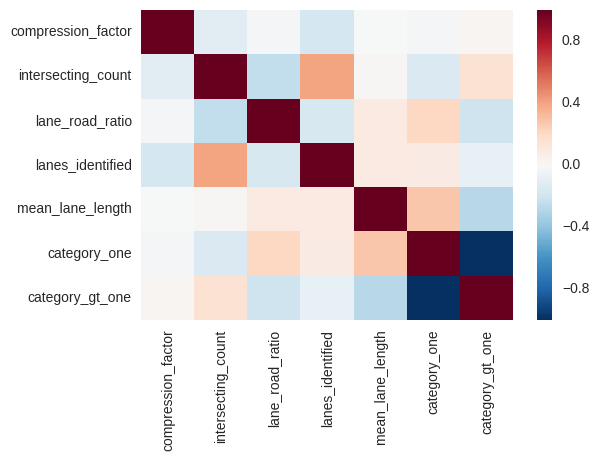

In [259]:
corr = train_feats.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.show()